# *Spectral clustering* algorithm

This notebook is an exploratory analysis based on "A Tutorial on Spectral Clustering" written by Ulrike von Luxburg implemented by zhangyk8. Below, we demonstrate a few examples of usage of said implementation and provide a short explanation of all the processes happening 'under the hood'.

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
## IMPORT NECESAERy LIBRARIES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split as tts  # hehe

from scipy.stats import norm

from itertools import product

from spectral_clustering import *
from stability_analysis import *
from parameter_fitting import *

In [3]:
import warnings

warnings.filterwarnings(
    "ignore", message="KMeans is known to have a memory leak on Windows with MKL"
)

### **Defining the function and explaining it**:

In [4]:
# def Spectral_Clustering(
#     X,
#     K=8,
#     adj=True,
#     metric="euclidean",
#     sim_graph="fully_connect",
#     sigma=1,
#     knn=10,
#     epsi=0.5,
#     normalized=1,
#     random_state=None,
# ):
#     """
#     Input:
#         X :
#             - If adj=True: assumed to be a precomputed pairwise distance / adjacency
#               matrix of shape [n_samples, n_samples].
#               If it's not square, we will treat it as raw data and compute distances.
#             - If adj=False: raw data of shape [n_samples, n_features].

#         K: int, number of clusters.
#         adj: bool, whether X is precomputed adjacency / distance (see above).
#         metric: distance metric for pdist() when adj=False. Default: 'euclidean'.
#         sim_graph: type of similarity graph:
#             'fully_connect', 'eps_neighbor', 'knn', 'mutual_knn'.
#         sigma: float, scale for fully connected RBF-like similarity.
#         knn: int, #neighbors for kNN/mutual-kNN graphs.
#         epsi: float, epsilon threshold for eps-neighbor graph.
#         normalized:
#             1 → random walk normalized Laplacian,
#             2 → symmetric normalized Laplacian,
#             otherwise → unnormalized Laplacian.
#         random_state: int or None, passed to KMeans.

#     Output:
#         Fitted sklearn.cluster.KMeans object with:
#             .cluster_centers_, .labels_, .inertia_, .n_iter_
#     """

#     # ---------------------------------------------------------------------
#     # 1) Build pairwise *distance* matrix (Adj_mat)
#     # ---------------------------------------------------------------------
#     X = np.asarray(X)

#     if adj:
#         # User claims X is precomputed adjacency / distance.
#         # If it's not square, fall back to "raw data" mode.
#         if X.ndim != 2 or X.shape[0] != X.shape[1]:
#             # Treat as raw data and compute pairwise distances
#             Adj_mat = squareform(pdist(X, metric=metric))
#         else:
#             Adj_mat = X
#     else:
#         # adj=False → X is raw data, compute pairwise distances
#         Adj_mat = squareform(pdist(X, metric=metric))

#     n_samples = Adj_mat.shape[0]

#     # ---------------------------------------------------------------------
#     # 2) Build similarity graph W from distance matrix Adj_mat
#     # ---------------------------------------------------------------------
#     if sim_graph == "fully_connect":
#         # Fully connected graph with Gaussian-like similarity
#         # W_ij = exp(-d_ij / (2 * sigma))
#         W = np.exp(-Adj_mat / (2 * sigma))

#     elif sim_graph == "eps_neighbor":
#         # ε-neighborhood graph: unweighted edges where d_ij <= epsi
#         W = (Adj_mat <= epsi).astype(float)
#         # Optional: remove self-loops (depends on your convention)
#         # np.fill_diagonal(W, 0.0)

#     elif sim_graph == "knn":
#         # k-Nearest Neighbor graph (symmetric union version)
#         W = np.zeros_like(Adj_mat, dtype=float)
#         # For each point, sort neighbors by distance
#         Adj_sort = np.argsort(Adj_mat, axis=1)
#         for i in range(n_samples):
#             # include self + k nearest neighbors
#             neighbors = Adj_sort[i, : (knn + 1)]
#             W[i, neighbors] = 1.0
#         # Symmetrize by union of edges
#         W = np.maximum(W, W.T)
#         # Optional: remove self-loops
#         # np.fill_diagonal(W, 0.0)

#     elif sim_graph == "mutual_knn":
#         # Mutual kNN: edge only if i is in kNN(j) and j is in kNN(i)
#         W_dir = np.zeros_like(Adj_mat, dtype=float)
#         Adj_sort = np.argsort(Adj_mat, axis=1)
#         for i in range(n_samples):
#             neighbors = Adj_sort[i, : (knn + 1)]
#             W_dir[i, neighbors] = 1.0
#         # mutual: intersection
#         W = np.logical_and(W_dir == 1.0, W_dir.T == 1.0).astype(float)
#         # Optional: keep or remove self-loops
#         # np.fill_diagonal(W, 0.0)

#     else:
#         raise ValueError(
#             "sim_graph must be one of "
#             "'fully_connect', 'eps_neighbor', 'knn', or 'mutual_knn'."
#         )

#     # ---------------------------------------------------------------------
#     # 3) Degree matrix D and *unnormalized* Laplacian L = D - W
#     # ---------------------------------------------------------------------
#     degrees = np.sum(W, axis=1)
#     D = np.diag(degrees)
#     L = D - W

#     # ---------------------------------------------------------------------
#     # 4) Eigen-decomposition depending on Laplacian type
#     # ---------------------------------------------------------------------
#     if normalized == 1:
#         # Random walk Laplacian: L_rw = D^{-1} L
#         with np.errstate(divide="ignore", invalid="ignore"):
#             inv_degrees = 1.0 / degrees
#         inv_degrees[~np.isfinite(inv_degrees)] = 0.0
#         D_inv = np.diag(inv_degrees)
#         L_rw = D_inv @ L
#         # L_rw is generally not symmetric → use eig
#         Lambdas, V = np.linalg.eig(L_rw)

#         # sort by |lambda|
#         idx = np.argsort(np.abs(Lambdas))
#         V_K = np.real(V[:, idx[:K]])

#     elif normalized == 2:
#         # Symmetric normalized Laplacian: L_sym = D^{-1/2} L D^{-1/2}
#         with np.errstate(divide="ignore", invalid="ignore"):
#             inv_sqrt_deg = 1.0 / np.sqrt(degrees)
#         inv_sqrt_deg[~np.isfinite(inv_sqrt_deg)] = 0.0
#         D_inv_sqrt = np.diag(inv_sqrt_deg)
#         L_sym = D_inv_sqrt @ L @ D_inv_sqrt

#         # L_sym is symmetric → eigh is better
#         Lambdas, V = np.linalg.eigh(L_sym)

#         idx = np.argsort(np.abs(Lambdas))
#         V_K = np.real(V[:, idx[:K]])

#         # Row-normalize embedding (Ng–Jordan–Weiss)
#         row_norms = np.linalg.norm(V_K, axis=1, keepdims=True)
#         # Avoid division by zero
#         row_norms[row_norms == 0] = 1.0
#         V_K = V_K / row_norms

#     else:
#         # Unnormalized Laplacian
#         Lambdas, V = np.linalg.eig(L)
#         idx = np.argsort(np.abs(Lambdas))
#         V_K = np.real(V[:, idx[:K]])

#     # ---------------------------------------------------------------------
#     # 5) K-means in spectral embedding space
#     # ---------------------------------------------------------------------
#     kmeans = KMeans(
#         n_clusters=K,
#         init="k-means++",
#         n_init="auto",  # or a fixed int if you prefer
#         random_state=random_state,
#     ).fit(V_K)

#     return kmeans

This function implements **spectral clustering** in the “graph Laplacian + eigenvectors + K-Means” style described in von Luxburg’s tutorial.

---

#### 1. Input and distance matrix

We start from `X`, which can be:

- **Raw data** (points in $\mathbb{R}^d$) if `adj=False`.
- A **precomputed pairwise distance / adjacency matrix** if `adj=True`.

If `adj=False`, we compute a **pairwise distance matrix**:

$$
\text{Adj\_mat}_{ij} = \text{dist}(x_i, x_j)
$$

using `pdist(..., metric=metric)` and `squareform`.  
This matrix is *not* yet the similarity matrix; it holds distances.

---

#### 2. Build the similarity graph $ W $

Next, we build a **similarity graph** on the data. The nodes are the data points, and the edges are weighted by a similarity value. The result is a **weighted adjacency matrix** $ W $, where:

$$
W_{ij} \ge 0 \quad \text{measures how similar } x_i \text{ and } x_j \text{ are}.
$$

The code supports several graph constructions (`sim_graph`):

1. **`fully_connect`**  
   Fully connected graph with a Gaussian-like kernel:
   $$
   W_{ij} = \exp\left(- \frac{\text{Adj\_mat}_{ij}}{2\sigma}\right).
   $$
   Every pair of points is connected, but far-away points have very small weights.

2. **`eps_neighbor`** (ε-neighborhood graph)  
   Unweighted graph where:
   $$
   W_{ij} =
   \begin{cases}
   1 & \text{if } \text{Adj\_mat}_{ij} \le \varepsilon, \\
   0 & \text{otherwise.}
   \end{cases}
   $$
   Only points closer than `epsi` are connected.

3. **`knn`** (k-nearest neighbor graph)  
   For each point $i$, we connect it to its `knn` closest neighbors (plus itself) with weight 1:
   $$
   W_{ij} = 1 \quad \text{if } j \text{ is among the k nearest neighbors of } i.
   $$
   This may be **asymmetric** (i can see j as neighbor while j doesn’t see i).

4. **`mutual_knn`** (mutual k-NN graph)  
   An edge between $i$ and $j$ is kept only if **both** are in each other’s k-nearest neighbors.  
   The code first flags potential edges, then keeps only those that are mutual. This yields a **symmetric** sparse graph that only connects points with strong mutual similarity.

At the end of this step we have:

- **Similarity / weighted adjacency matrix** $ W \in \mathbb{R}^{n \times n} $.

---

#### 3. Degree matrix $ D $ and unnormalized Laplacian $ L $

From $ W $, we compute the **degree matrix** $ D $:

$$
D_{ii} = \sum_{j} W_{ij}, \quad D_{ij} = 0 \text{ for } i \neq j.
$$

Then the **unnormalized graph Laplacian** is:

$$
L = D - W.
$$

This $L$ encodes the graph structure: for example, in the ideal case of $K$ disconnected components, $L$ has exactly $K$ zero eigenvalues and its eigenvectors correspond to indicator vectors of the components.

---

#### 4. Choose and construct the Laplacian variant

Depending on the parameter `normalized`, the code uses different Laplacians:

1. **Unnormalized Laplacian** (`normalized` not 1 or 2):
   $$
   L_{\text{unnorm}} = L = D - W.
   $$

2. **Random walk normalized Laplacian** (`normalized == 1`):
   $$
   L_{rw} = D^{-1} L = I - D^{-1} W.
   $$
   This can be interpreted in terms of a random walk on the graph.

3. **Symmetric normalized Laplacian** (`normalized == 2`):
   $$
   L_{sym} = D^{-1/2} L D^{-1/2} = I - D^{-1/2} W D^{-1/2}.
   $$
   This is the Laplacian used in the Ng–Jordan–Weiss spectral clustering algorithm.

The code explicitly constructs and diagonalizes the chosen Laplacian:

- For `normalized == 1`: eigen-decomposition of $ D^{-1} L $.
- For `normalized == 2`: eigen-decomposition of $ D^{-1/2} L D^{-1/2} $.
- Otherwise: eigen-decomposition of $ L $.

---

#### 5. Eigenvectors and spectral embedding

Let $(\lambda_k, v_k)$ be eigenpairs of the chosen Laplacian. The code:

1. **Sorts eigenvalues** by magnitude (smallest first).
2. **Takes the first $K$ eigenvectors**, forming a matrix:
   $$
   V_K = [v_1, v_2, \dots, v_K] \in \mathbb{R}^{n \times K}.
   $$

Each row of $V_K$ is a **new representation** of the corresponding data point:

$$
y_i = \text{row } i \text{ of } V_K \in \mathbb{R}^K.
$$

In the symmetric normalized case (`normalized == 2`), the rows of $V_K$ are additionally **normalized to have unit length**, which is exactly the Ng–Jordan–Weiss algorithm step. Intuitively:

- Points from the same cluster have **similar eigenvector coordinates**.
- Points from different clusters are pushed apart in this spectral space.

So this step transforms the original data into an embedding where the cluster structure is easier to separate.

---

#### 6. K-Means in spectral space

Finally, we run **K-Means** on the rows of $V_K$:

- Input to K-Means: the matrix $ V_K \in \mathbb{R}^{n \times K} $.
- Output: cluster assignment for each point.

The returned object is the fitted `KMeans` model from `sklearn`, whose `labels_` attribute gives the final cluster labels. Conceptually:

1. Graph + similarity → Laplacian.
2. Laplacian → eigenvectors → spectral embedding.
3. Spectral embedding → K-Means → cluster labels.

Spectral clustering is thus:
> **Graph-based feature construction (via Laplacian eigenvectors) + standard K-Means on those features.**

### **Merging** `Spectral_Clustering` **funcitons**: `Spectral_Clustering2`

Make function that handles all logic from this code and modifies the core logics acoording to @Vladimir's version. This will prevent us from obtaining different results.

In [5]:
# def get_distance_matrix_from_data(X, metric="euclidean"):
#     """
#     X: [n_samples, n_features] data matrix.
#     Returns: [n_samples, n_samples] distance matrix.
#     """
#     X = np.asarray(X)
#     return squareform(pdist(X, metric=metric))


# def get_similarity_matrix_from_distance_matrix(
#     distance_matrix,
#     sim_graph="fully_connect",
#     sigma=1.0,
#     knn=10,
#     mutual_knn=None,
#     epsilon=0.5,
# ):
#     """
#     Build similarity (weight) matrix W from pairwise distances.
#     - fully_connect: Gaussian-like kernel exp(-d / (2*sigma))
#     - eps_neighbor: 1 if d <= epsilon
#     - knn: symmetric kNN (union)
#     - mutual_knn: symmetric mutual kNN (intersection)
#     """
#     distance_matrix = np.asarray(distance_matrix)
#     n = distance_matrix.shape[0]

#     if sim_graph == "fully_connect":
#         W = np.exp(-distance_matrix / (2 * sigma))

#     elif sim_graph == "eps_neighbor":
#         W = (distance_matrix <= epsilon).astype(float)

#     elif sim_graph == "knn":
#         W = np.zeros_like(distance_matrix, dtype=float)
#         closest = np.argsort(distance_matrix, axis=1)
#         for i in range(n):
#             nbrs = closest[i, : (knn + 1)]  # self + k neighbors
#             W[i, nbrs] = 1.0
#         # symmetric union
#         W = np.maximum(W, W.T)

#     elif sim_graph == "mutual_knn":
#         if mutual_knn is None:
#             mutual_knn = knn
#         closest = np.argsort(distance_matrix, axis=1)
#         neighbors = np.zeros((n, n), dtype=bool)
#         for i in range(n):
#             nbrs = closest[i, : (mutual_knn + 1)]
#             neighbors[i, nbrs] = True
#         # mutual kNN: intersection
#         W = (neighbors & neighbors.T).astype(float)

#     else:
#         raise ValueError(
#             "sim_graph must be one of "
#             "'fully_connect', 'eps_neighbor', 'knn', or 'mutual_knn'."
#         )

#     return W


# def count_connected_components(W):
#     """
#     Count connected components in the undirected graph induced by W>0.
#     """
#     W = np.asarray(W)
#     if W.size == 0:
#         return 0
#     adjacency = (W > 0).astype(int)
#     graph = nx.from_numpy_array(adjacency)
#     return nx.number_connected_components(graph)


# def _spectral_clustering_from_similarity(
#     W,
#     K=8,
#     normalized=1,
#     random_state=None,
#     check_components=True,
#     return_eigen=False,
# ):
#     """
#     Core spectral clustering given a similarity (weight) matrix W.

#     Returns:
#         - if return_eigen=False: kmeans
#         - if return_eigen=True : (kmeans, V_K, eigenvalues_sorted)
#     """
#     W = np.asarray(W)
#     n = W.shape[0]

#     if check_components:
#         num_components = count_connected_components(W)
#         if num_components > K:
#             raise ValueError(
#                 "Similarity graph contains more connected components "
#                 f"({num_components}) than K={K}."
#             )

#     # Degree matrix & Laplacian
#     degrees = np.sum(W, axis=1)
#     D = np.diag(degrees)
#     L = D - W

#     # ----- eigen-decomposition -----
#     if normalized == 1:
#         # Random walk: L_rw = D^{-1} L
#         with np.errstate(divide="ignore", invalid="ignore"):
#             inv_deg = 1.0 / degrees
#         inv_deg[~np.isfinite(inv_deg)] = 0.0
#         D_inv = np.diag(inv_deg)
#         L_rw = D_inv @ L

#         eigenvalues, eigenvectors = np.linalg.eig(L_rw)
#         idx = np.argsort(np.abs(eigenvalues))
#         V_K = np.real(eigenvectors[:, idx[:K]])
#         eigenvalues_sorted = eigenvalues[idx]

#     elif normalized == 2:
#         # Symmetric normalized: L_sym = D^{-1/2} L D^{-1/2}
#         with np.errstate(divide="ignore", invalid="ignore"):
#             inv_sqrt_deg = 1.0 / np.sqrt(degrees)
#         inv_sqrt_deg[~np.isfinite(inv_sqrt_deg)] = 0.0
#         D_inv_sqrt = np.diag(inv_sqrt_deg)
#         L_sym = D_inv_sqrt @ L @ D_inv_sqrt

#         # L_sym is symmetric → eigh
#         eigenvalues, eigenvectors = np.linalg.eigh(L_sym)
#         idx = np.argsort(np.abs(eigenvalues))
#         V_K = np.real(eigenvectors[:, idx[:K]])
#         eigenvalues_sorted = eigenvalues[idx]

#         # Ng–Jordan–Weiss row normalization
#         row_norms = np.linalg.norm(V_K, axis=1, keepdims=True)
#         row_norms[row_norms == 0] = 1.0
#         V_K = V_K / row_norms

#     else:
#         # Unnormalized Laplacian L
#         # L is symmetric if W is symmetric, so eigh is fine
#         eigenvalues, eigenvectors = np.linalg.eigh(L)
#         idx = np.argsort(np.abs(eigenvalues))
#         V_K = np.real(eigenvectors[:, idx[:K]])
#         eigenvalues_sorted = eigenvalues[idx]

#     # ----- KMeans on embedding -----
#     kmeans = KMeans(
#         n_clusters=K,
#         init="k-means++",
#         n_init="auto",
#         random_state=random_state,
#     ).fit(V_K)

#     if return_eigen:
#         return kmeans, V_K, eigenvalues_sorted
#     else:
#         return kmeans


# def Spectral_Clustering2(
#     X,
#     K=8,
#     adj=True,
#     metric="euclidean",
#     sim_graph="fully_connect",
#     sigma=1,
#     knn=10,
#     epsi=0.5,
#     normalized=1,
#     random_state=None,
#     check_components=True,
#     return_eigen=False,
# ):
#     """
#     High-level spectral clustering interface (Rafa + Vladimir).

#     X:
#         - If adj=True and X is square: treated as a *distance matrix*.
#         - Otherwise: treated as raw data, and pairwise distances are computed.

#     sim_graph: 'fully_connect', 'eps_neighbor', 'knn', 'mutual_knn'
#     epsi    : epsilon threshold (for eps_neighbor)
#     sigma   : bandwidth (for fully_connect)
#     knn     : #neighbors for knn / mutual_knn

#     Returns:
#         - if return_eigen=False: kmeans
#         - if return_eigen=True : (kmeans, V_K, eigenvalues_sorted)
#     """
#     X = np.asarray(X)

#     # --- 1) Distance matrix ---
#     if adj and X.ndim == 2 and X.shape[0] == X.shape[1]:
#         # user gave us a square matrix -> assume distances
#         distance_matrix = X
#     else:
#         # raw data → compute distances
#         distance_matrix = get_distance_matrix_from_data(X, metric=metric)

#     # --- 2) Similarity matrix ---
#     W = get_similarity_matrix_from_distance_matrix(
#         distance_matrix,
#         sim_graph=sim_graph,
#         sigma=sigma,
#         knn=knn,
#         mutual_knn=knn,  # same number for mutual knn by default
#         epsilon=epsi,
#     )

#     # --- 3) Run core spectral clustering from W ---
#     return _spectral_clustering_from_similarity(
#         W,
#         K=K,
#         normalized=normalized,
#         random_state=random_state,
#         check_components=check_components,
#         return_eigen=return_eigen,
#     )

### **Example usage**: `Spectral_Clustering`

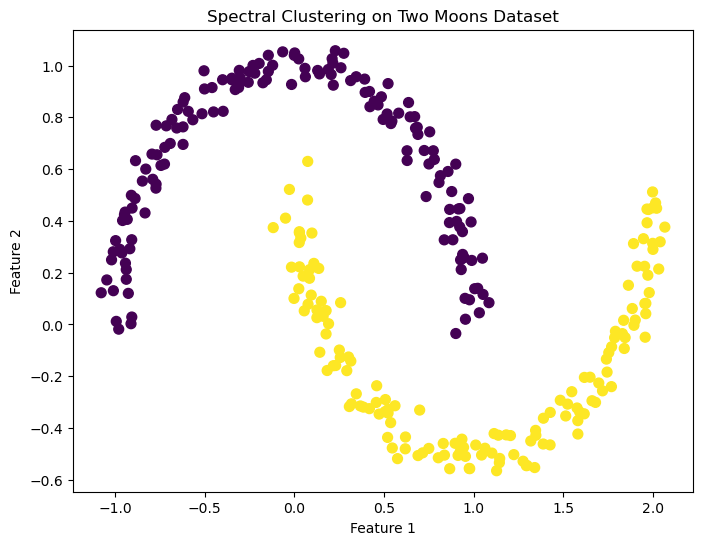

In [6]:
## TWO MOONS DATASET EXAMPLE
X_moons, _ = make_moons(
    n_samples=300, noise=0.05, random_state=1
)  # Generate two moons dataset (literally two moons of points in A_{R}^2)

distance_matrix = get_distance_matrix_from_data(X_moons)
similarity_matrix = get_similarity_matrix_from_distance_matrix(
    distance_matrix, sim_graph_type="mutual_knn", mutual_knn=10
)

kmeans_moons = Spectral_Clustering(
    similarity_matrix, K=2, normalized=3, random_state=1
).clustering_model

labels_moons = kmeans_moons.labels_

# Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=labels_moons, cmap="viridis", s=50)
plt.title("Spectral Clustering on Two Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### **Observations**:
- Similarity graph = `knn`: For this similarity graph, the clustering technique seems to work great whenever we have $6 \leq \operatorname{knn} < 25$ . We tried different laplacians but there seems to be little to no difference in the resulting clusters within this bound. Whenever we go beyond or below the number of neighbours the clusters start getting quite interesting for all laplacians.
- Similarity graph = `mutual_knn`: This similarity graph seems to have more tolerance towards a greater number of negihbours for the kmeans algorithm. It's bound for optimal performance seems to be $8 \leq \operatorname{knn} \leq 45$ (might *missclassify* one or two datapoints).
- Similarity graph = `fully_connect`: Bad choice for similarity graph. No change as for choice of laplacian neither the number of neighbours.
- Similarity graph = `eps_neighbor`: Consistent choice! It does not seem to budge much from the 'default' setting. Although it does not yield a perfect classification, it provides the most consistent results over the choice of laplacian (this does not seem to have an effect at all!) and the choice of neighbours for the kmeans algorithm.

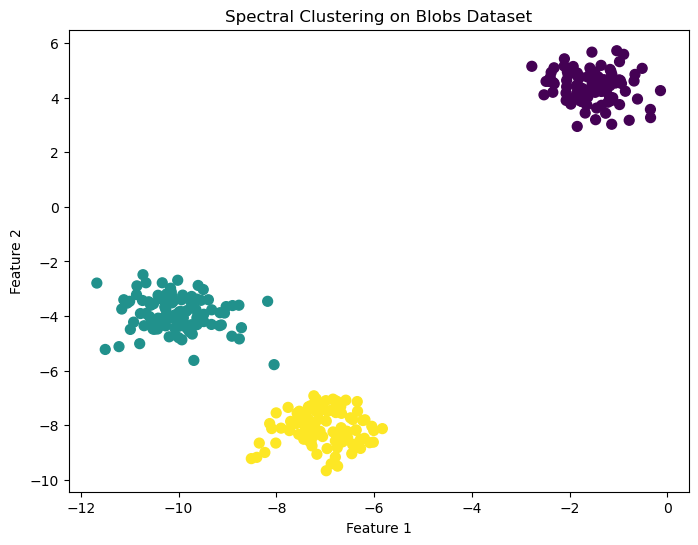

In [7]:
## MAKE BLOBS DATASET EXAMPLE
X_blobs, _ = make_blobs(
    n_samples=300, centers=3, cluster_std=0.60, random_state=1
)  # Generate 3 gaussian blobs (well separated)

distance_matrix = get_distance_matrix_from_data(X_blobs)
similarity_matrix = get_similarity_matrix_from_distance_matrix(
    distance_matrix, sim_graph_type="mutual_knn", mutual_knn=10
)

kmeans_blobs = Spectral_Clustering(
    similarity_matrix, K=3, normalized=2, random_state=1
).clustering_model

labels_blobs = kmeans_blobs.labels_

# Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=labels_blobs, cmap="viridis", s=50)
plt.title("Spectral Clustering on Blobs Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

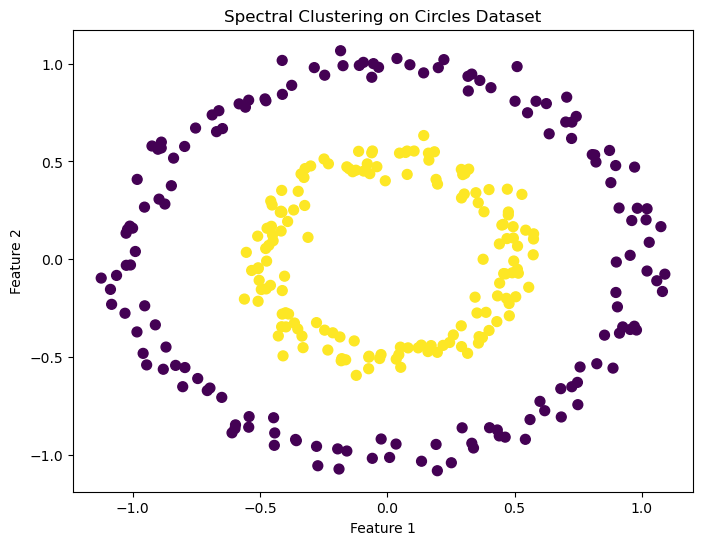

In [8]:
# MAKE CIRCLES DATASET EXAMPLE
X_circle, _ = make_circles(
    n_samples=300, noise=0.05, factor=0.5, random_state=1
)  # Generate concentric circles dataset

distance_matrix = get_distance_matrix_from_data(X_circle)
similarity_matrix = get_similarity_matrix_from_distance_matrix(
    distance_matrix, sim_graph_type="knn", knn=10
)

kmeans_circles = Spectral_Clustering(
    similarity_matrix, K=2, normalized=2, random_state=1
).clustering_model

labels_circles = kmeans_circles.labels_

# Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=labels_circles, cmap="viridis", s=50)
plt.title("Spectral Clustering on Circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### **Example usage:** `Spectral_Clustering2`

exactly the same as the other function (sanity check)

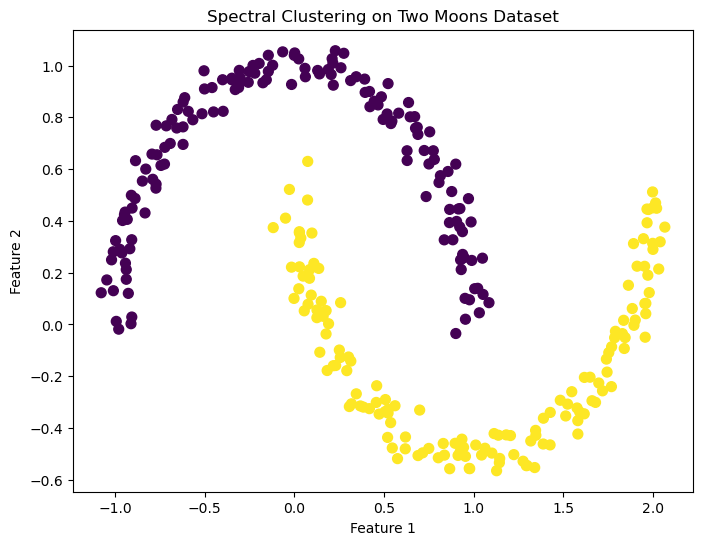

In [9]:
## MAKE MOONS DATASET EXAMPLE
distance_matrix = get_distance_matrix_from_data(X_circle)
similarity_matrix = get_similarity_matrix_from_distance_matrix(
    distance_matrix, sim_graph_type="knn", knn=10
)

kmeans_circles2 = Spectral_Clustering(
    similarity_matrix, K=2, normalized=2, random_state=1
).clustering_model

labels_moons2 = kmeans_circles2.labels_

# Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=labels_moons2, cmap="viridis", s=50)
plt.title("Spectral Clustering on Two Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

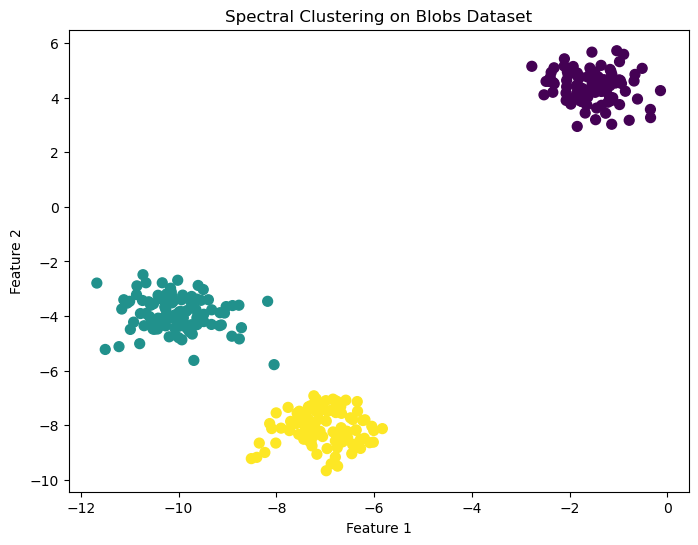

In [10]:
## MAKE BLOBS DATASET EXAMPLE
distance_matrix = get_distance_matrix_from_data(X_blobs)
similarity_matrix = get_similarity_matrix_from_distance_matrix(
    distance_matrix, sim_graph_type="mutual_knn", mutual_knn=10
)

kmeans_blobs2 = Spectral_Clustering(
    similarity_matrix, K=3, normalized=2, random_state=1
).clustering_model

labels_blobs2 = kmeans_blobs2.labels_

# Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=labels_blobs2, cmap="viridis", s=50)
plt.title("Spectral Clustering on Blobs Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### **Recreating `figure 1` from the paper (Spectral Clustering Tutorial, Luxburgf)**

We now try to reproduce the classical spectral clustering toy example from von Luxburg’s tutorial: a 1D dataset obtained by sampling from four Gaussian distributions whose means are aligned on a line and “adjoined”.

- **Data generation**

We sample points from the following one-dimensional Gaussians:

- $ \mathcal{N}(\mu_1, 1) $ with $ \mu_1 = 2 $
- $ \mathcal{N}(\mu_2, 1) $ with $ \mu_2 = 4 $
- $ \mathcal{N}(\mu_3, 1) $ with $ \mu_3 = 6 $
- $ \mathcal{N}(\mu_4, 1) $ with $ \mu_4 = 8 $

All Gaussians have variance $ \sigma^2 = 1 $ and we use the same number of
samples per cluster. The final dataset is a 1D array $ x_1,\dots,x_n $.

- **Graph construction**

From these points we build a similarity graph in the same style as our
`Spectral_Clustering` implementation:

1. Compute the pairwise distance matrix  
   $ \text{Adj\_mat}_{ij} = |x_i - x_j| $ (Euclidean distance in 1D).
2. Turn distances into **similarities** to obtain the weighted adjacency matrix $W$.
   We can choose different similarity graphs:
   - **Fully connected** graph:
     $$
     W_{ij} = \exp\left(-\frac{\text{Adj\_mat}_{ij}}{2\,\sigma_W}\right)
     $$
     where $ \sigma_W $ is a scale parameter (RBF-like kernel).
   - **k-nearest neighbor (kNN)** graph:
     connect each point with weight 1 to its $k$ nearest neighbors (plus itself).

So $W$ is the **similarity / weighted adjacency matrix** of our graph, and it
depends on both the graph type (`fully_connect` vs `knn`) and its parameters
($\sigma_W$, `knn`, etc.).

- **Laplacians**

Given $W$, we define the **degree matrix** $D$ by

$$
D_{ii} = \sum_j W_{ij}, \quad D_{ij} = 0 \text{ for } i \neq j,
$$

and the **unnormalized Laplacian**:

$$
L = D - W.
$$

From this, we can form different Laplacian variants:

  **Unnormalized Laplacian**:
  $$
  L_{\mathrm{unnorm}} = L.
  $$
  **Random walk normalized Laplacian**:
  $$
  L_{rw} = D^{-1} L = I - D^{-1} W.
  $$

These correspond to the “unnormalized spectral clustering” and the “random walk
spectral clustering” versions in Luxburg’s tutorial.

- **Spectral decomposition**

For each chosen Laplacian (and similarity graph), we compute its eigenvalues
and eigenvectors:

$$
L \, v_k = \lambda_k \, v_k.
$$

We sort the eigenvalues $ \lambda_k $ in ascending order and gather the
corresponding eigenvectors. Each eigenvector is a function on the nodes (data
points), so for a 1D dataset we can visualize the $k$-th eigenvector as a
curve $ i \mapsto v_k(i) $ along the sorted points.


In [11]:
# ## GENERATE 1D TOY DATA
# def generate_four_gaussians(
#     n_per_cluster=100, means: tuple = [2, 4, 6, 8], std=1.0, seed=1
# ):
#     rng = np.random.default_rng(seed)
#     X_list = []
#     labels_list = []
#     for k, mu in enumerate(means):
#         X_k = rng.normal(loc=mu, scale=std, size=n_per_cluster)
#         X_list.append(X_k)
#         labels_list.append(np.full(n_per_cluster, k))
#     X = np.concatenate(X_list)  # shape (n,)
#     labels = np.concatenate(labels_list)  # ground-truth cluster ids 0..3
#     return X.reshape(-1, 1), labels


# ## GENERATE SIMILARITY MATRIX
# def build_similarity_matrix_gaussian(X, sim_graph="fully_connect", sigma=1.0, knn=10):
#     """
#     Build similarity matrix W using Gaussian kernel with variance sigma^2.
#       W_ij = exp( - ||x_i - x_j||^2 / (2 sigma^2) )
#     For 'knn', we keep only k nearest neighbors (plus self) and zero out others.
#     """
#     # Pairwise Euclidean distances
#     Adj_mat = squareform(pdist(X, metric="euclidean"))
#     n = Adj_mat.shape[0]

#     # Full Gaussian similarity matrix
#     W_full = np.exp(-(Adj_mat**2) / (2.0 * sigma**2))

#     if sim_graph == "fully_connect":
#         # Fully connected Gaussian graph
#         W = W_full
#     elif sim_graph == "knn":
#         # kNN Gaussian graph: keep only k nearest edges (plus self)
#         W = np.zeros_like(W_full)
#         idx_sorted = np.argsort(Adj_mat, axis=1)
#         for i in range(n):
#             # include self + k nearest neighbors
#             neigh_idx = idx_sorted[i, : knn + 1]
#             W[i, neigh_idx] = W_full[i, neigh_idx]
#         # symmetrize (use max to keep stronger weight if only one direction)
#         W = np.maximum(W, W.T)
#     else:
#         raise ValueError("sim_graph must be 'fully_connect' or 'knn'")

#     return W, Adj_mat


# ## CONSTRICT LAPLACAIANS
# def build_laplacians(W):
#     """
#     Given similarity matrix W, build:
#       - Degree matrix D
#       - Unnormalized Laplacian L = D - W
#       - Random-walk Laplacian L_rw = D^{-1} L
#     """
#     d = np.sum(W, axis=1)
#     D = np.diag(d)
#     L = D - W
#     with np.errstate(divide="ignore"):
#         inv_d = np.where(d > 0, 1.0 / d, 0.0)
#     D_inv = np.diag(inv_d)
#     L_rw = D_inv @ L
#     return D, L, L_rw


# ## COMPUTE EIGENTHINGS (SPECTRUM)
# def compute_spectrum(L, symmetric=True):
#     """
#     Compute eigenvalues and eigenvectors of Laplacian L.
#     If symmetric=True, use eigh (for symmetric real matrices).
#     Otherwise use eig and keep real parts.
#     Returns (eigenvalues_sorted, eigenvectors_sorted).
#     """
#     if symmetric:
#         lambdas, V = np.linalg.eigh(L)
#     else:
#         lambdas, V = np.linalg.eig(L)
#         lambdas = np.real(lambdas)
#         V = np.real(V)
#     idx = np.argsort(lambdas)
#     lambdas = lambdas[idx]
#     V = V[:, idx]
#     return lambdas, V


# ## HELPER FUNCTION FOR LPOTTING
# def plot_luxburg_figure(X, specs, n_eigvecs=5, n_eigvals_to_show=10):
#     """
#     Reproduce a layout similar to Luxburg Fig.1.

#     X      : (n,1) data.
#     specs  : list of tuples (label, lambdas, V)
#              in the order of rows (excluding the histogram row).
#     n_eigvecs         : how many eigenvectors to show per row.
#     n_eigvals_to_show : how many smallest eigenvalues to display.

#     Row 0: histogram of X.
#     Rows 1..len(specs): for each spec
#         col 0: eigenvalues
#         col 1..n_eigvecs: eigenvectors 1..n_eigvecs
#     """

#     x = X.squeeze()
#     n = len(x)

#     # Sort by position once so all eigenvectors are plotted over the same x-order
#     sort_idx = np.argsort(x)
#     x_sorted = x[sort_idx]

#     n_rows = len(specs) + 1  # +1 for histogram
#     n_cols = n_eigvecs + 1  # eigenvalues + eigenvectors

#     fig = plt.figure(figsize=(14, 10))
#     gs = fig.add_gridspec(n_rows, n_cols, height_ratios=[1] + [1] * len(specs))

#     # --- Row 0: histogram of the sample ---
#     ax_hist = fig.add_subplot(gs[0, :])
#     ax_hist.hist(x, bins=40, color="b")
#     ax_hist.set_title("Histogram of the sample")
#     ax_hist.set_xlim(x.min() - 0.5, x.max() + 0.5)

#     # --- Remaining rows: eigenvalues + eigenvectors ---
#     for row, (row_label, lambdas, V) in enumerate(specs, start=1):
#         # Sort eigenvectors in the same x-order
#         V_sorted = V[sort_idx, :]

#         # Column 0: eigenvalues (only first n_eigvals_to_show)
#         ax_eig = fig.add_subplot(gs[row, 0])
#         m = min(len(lambdas), n_eigvals_to_show)
#         ax_eig.plot(range(1, m + 1), lambdas[:m], marker="*", linestyle="none")
#         ax_eig.set_title("Eigenvalues" if row == 1 else "")
#         ax_eig.set_xlabel("")
#         ax_eig.set_ylabel(row_label)
#         ax_eig.set_xlim(0.5, m + 0.5)

#         # Columns 1..n_eigvecs: eigenvectors 1..n_eigvecs
#         for k in range(n_eigvecs):
#             ax_v = fig.add_subplot(gs[row, k + 1])
#             ax_v.plot(x_sorted, V_sorted[:, k])
#             if row == 1:
#                 ax_v.set_title(f"Eigenvector {k+1}")
#             else:
#                 ax_v.set_title("")
#             # Keep axis labeling minimal for aesthetics
#             if row == n_rows - 1:
#                 ax_v.set_xlabel("x")
#             else:
#                 ax_v.set_xlabel("")
#             ax_v.set_ylabel("")

#     plt.tight_layout()
#     plt.show()

In [12]:
# means = [2, 4, 6, 8]
# X_four_gaussians, y_four_gaussians = generate_four_gaussians(
#     n_per_cluster=100, std=0.25, seed=1
# )

# # --- 4. Visualize the Data ---
# plt.figure(figsize=(12, 6))

# # Create the histogram
# plt.hist(
#     X_four_gaussians,
#     bins=30,
#     density=True,
#     alpha=0.7,
#     color="skyblue",
#     edgecolor="black",
#     label="Generated Samples",
# )

# # Optional: Plot the true distribution PDFs for verification
# x = np.linspace(-2, 12, 1000)
# total_pdf = np.zeros_like(x)

# for mean in means:
#     # PDF of each individual component (scaled by 1/n_components)
#     pdf = norm.pdf(x, loc=mean, scale=0.25) / len(means)
#     total_pdf += pdf
#     # Plot individual component PDFs lightly
#     plt.plot(x, pdf, "g--", alpha=0.5)

# # Plot the total mixture PDF
# plt.plot(x, total_pdf, "r-", linewidth=2, label="True Mixture PDF")

# # Add titles and labels
# plt.title("Histogram of 200 Samples from a Gaussian Mixture Model")
# plt.xlabel("Value")
# plt.ylabel("Density")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

In [13]:
# X_four_gaussians = X_four_gaussians.reshape(-1, 1)  # Reshape to (n_samples, 1)

In [14]:
# ## CONSTRUCT SPECIFICATIONS FOR THAE PLOT
# # (1) kNN graph, L_rw
# W_knn, _ = build_similarity_matrix_gaussian(
#     X_four_gaussians, sim_graph="knn", sigma=1.0, knn=10
# )
# D_knn, L_knn, Lrw_knn = build_laplacians(W_knn)
# l_knn_rw, V_knn_rw = compute_spectrum(Lrw_knn, symmetric=False)  # L_rw is not symmetric

# # (2) kNN graph, unnormalized L
# l_knn_un, V_knn_un = compute_spectrum(L_knn, symmetric=True)

# # (3) fully connected graph, L_rw
# W_full, _ = build_similarity_matrix_gaussian(
#     X_four_gaussians, sim_graph="fully_connect", sigma=1.0
# )
# D_full, L_full, Lrw_full = build_laplacians(W_full)
# l_full_rw, V_full_rw = compute_spectrum(Lrw_full, symmetric=False)

# # (4) fully connected graph, unnormalized L
# l_full_un, V_full_un = compute_spectrum(L_full, symmetric=True)

# specs = [
#     ("norm, knn", l_knn_rw, V_knn_rw),
#     ("unnorm, knn", l_knn_un, V_knn_un),
#     ("norm, full graph", l_full_rw, V_full_rw),
#     ("unnorm, full graph", l_full_un, V_full_un),
# ]

# ## PLOT!
# plot_luxburg_figure(X_four_gaussians, specs, n_eigvecs=5, n_eigvals_to_show=10)

### **Similarity Graph Experiment**

Since in the spectral clustering algorithm almost everything is driven by **how we build the similarity graph** $G = (V, E)$ from the data; the Laplacian, its eigenvectors, and the final clusters all depend on this construction; we wish to analyze the distinct behaviours that each of the examples provided in the paper behave.

Following the paper's statements (Section 8), a reasonable rule of thumb is:

- **k-nearest neighbors (kNN)** – *good default*.  
  Connect each point to its $k$ nearest neighbors and symmetrize the graph. This is usually robust and works well even when clusters have different densities, as every point gets exactly $k$ neighbors.

- **Mutual kNN** – useful when clusters have **very different densities**.  
  Connect $i$ and $j$ only if each is in the other’s kNN list. This tends to connect points within the same dense region but avoids spurious links between regions of very different density. The trade-off: you often need a larger $k$ to keep the graph connected.

- **$\varepsilon$-neighborhood graph** – simple but **very sensitive** to $\varepsilon$.  
  Two points are connected if their distance is < $\varepsilon$. A single global $\varepsilon$ rarely works well when the data live on different scales or have varying densities, so this is usually not the first choice.

- **Fully connected + Gaussian kernel** – elegant but **σ-sensitive**.  
  All points are connected with a weight $w_{ij} = \exp(\frac{-\|x_i - x_j\|^2}{(2\sigma^2)})$. This has nice theoretical properties but in practice depends heavily on $\sigma$; too small $\rightarrow$ graph behaves like an $\varepsilon$-graph, too large $\rightarrow$ everything looks similar.

In practice:

- we typically **start with a kNN graph**,  
- consider **mutual kNN** if we know clusters differ strongly in density,  
- and only use $\varepsilon$-graphs or fully connected graphs when we have a good reason and careful parameter tuning.

In [15]:
rng = np.random.default_rng(0)

In order to demonstrate further the example given in the paper, we build a toy dataset: two circles, one moon, one Gaussian blob

In [16]:
def make_circle(n, radius=1.0, noise=0.03, center=(0.0, 0.0)):
    theta = rng.uniform(0, 2 * np.pi, size=n)
    r = radius + rng.normal(scale=noise, size=n)
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)
    return np.c_[x, y]


def make_moon(n, radius=1.0, width=0.25, center=(0.0, 0.0)):
    theta = rng.uniform(0, np.pi, size=n)
    r = radius + rng.normal(scale=width, size=n)
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)
    return np.c_[x, y]

In [17]:
# Circle 1: small, dense, near origin
circle1 = make_circle(n=250, radius=0.7, noise=0.02, center=(0.0, 0.0))

# Circle 2: larger, sparser, shifted right
circle2 = make_circle(n=120, radius=1.4, noise=0.05, center=(0.0, 0.0))

# Moon: curved cluster on the left
moon = make_moon(n=150, radius=1.0, width=0.15, center=(-1.5, -0.2))

# Gaussian blob: compact cluster far below
blob = rng.normal(loc=(0.8, -1.8), scale=(0.18, 0.22), size=(100, 2))

X = np.vstack([circle1, circle2, moon, blob])
labels = np.concatenate(
    [
        np.zeros(circle1.shape[0], dtype=int),  # 0: circle1
        np.ones(circle2.shape[0], dtype=int),  # 1: circle2
        2 * np.ones(moon.shape[0], dtype=int),  # 2: moon
        3 * np.ones(blob.shape[0], dtype=int),  # 3: blob
    ]
)

colors = np.array(["blue", "orange", "green", "red"])
node_colors = colors[labels]

Graph construction helpers

In [18]:
def epsilon_graph(X, eps):
    """Unweighted epsilkon-neighborhood graph."""
    D = cdist(X, X)
    W = (D < eps).astype(float)
    np.fill_diagonal(W, 0.0)
    return W


def knn_graph(X, k, mutual=False):
    """
    Symmetrized kNN graph.
    If mutual=False: connect if either i is in kNN(j) or j in kNN(i).
    If mutual=True: connect only if both are in each other's kNN.
    """
    n = X.shape[0]
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(X)
    dist, idx = nbrs.kneighbors(X)
    idx = idx[:, 1:]  # drop self

    W = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in idx[i]:
            W[i, j] = 1.0

    if mutual:
        W = np.minimum(W, W.T)  # keep only mutual edges
    else:
        W = np.maximum(W, W.T)  # symmetrize

    return W


def fully_connected_rbf(X, sigma):
    """Fully connected graph with Gaussian (RBF) weights."""
    D = cdist(X, X)
    W = np.exp(-(D**2) / (2 * sigma**2))
    np.fill_diagonal(W, 0.0)
    return W


def plot_graph(
    X, W, title, ax, node_colors, edge_alpha=0.12, edge_lw=0.35, node_size=12
):
    """Scatter plot of X with edges drawn where W_ij > 0."""
    ax.scatter(X[:, 0], X[:, 1], s=node_size, c=node_colors, zorder=2)

    rows, cols = np.where(W > 0)
    for i, j in zip(rows, cols):
        if i < j:  # avoid drawing each edge twice
            ax.plot(
                [X[i, 0], X[j, 0]],
                [X[i, 1], X[j, 1]],
                linewidth=edge_lw,
                alpha=edge_alpha,
                zorder=1,
            )

    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

Build graphs with reasonably chosen parameters

In [19]:
W_eps = epsilon_graph(X, eps=0.32)
W_knn = knn_graph(X, k=12, mutual=False)
W_mknn = knn_graph(X, k=12, mutual=True)
W_full = fully_connected_rbf(X, sigma=0.4)

Plot: first raw data, then we include the graph build

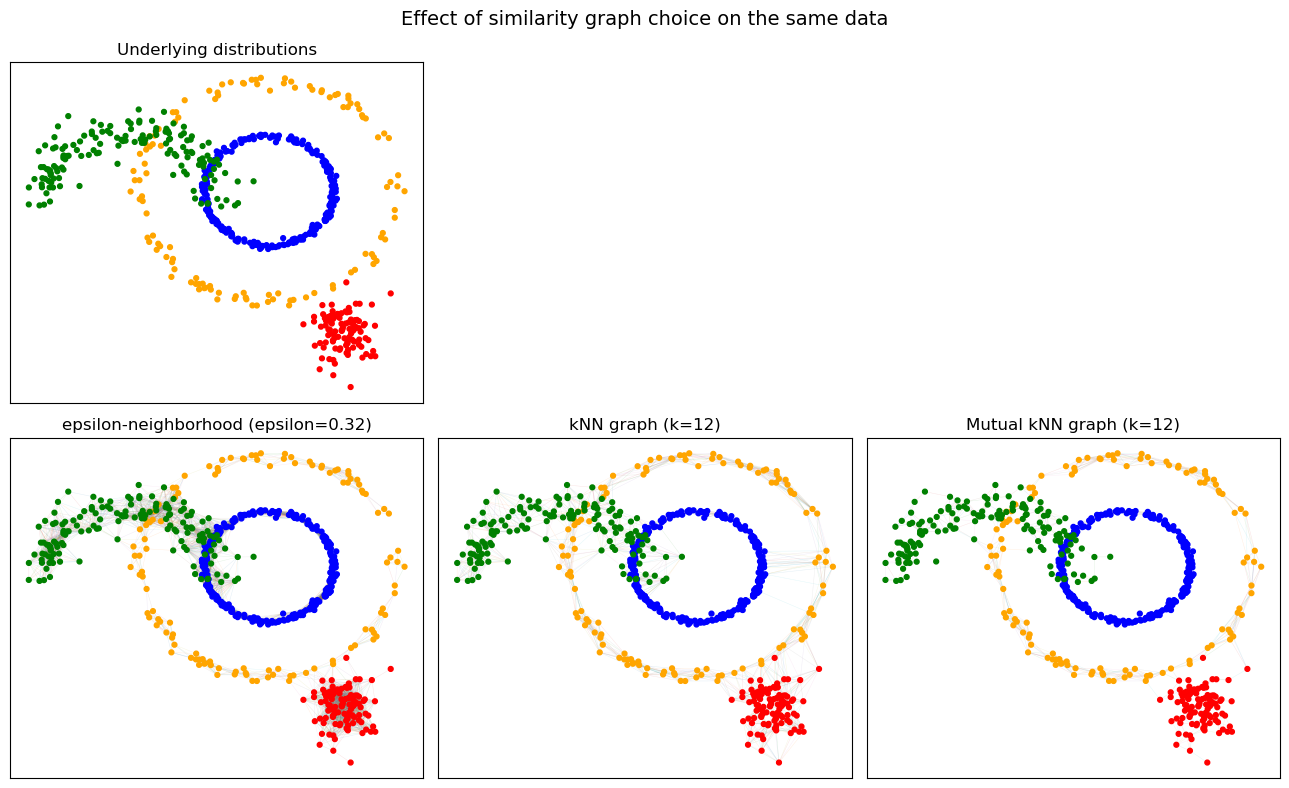

'\n# Optional: separate figure for the fully connected RBF graph\nfig2, ax2 = plt.subplots(figsize=(5, 5))\nplot_graph(X, W_full, "Fully connected (RBF, sigma=0.4)", ax2, node_colors, edge_alpha=0.05, edge_lw=0.25)\nplt.tight_layout()\nplt.show()\n'

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(13, 8))

# Raw data with true components
axes[0, 0].scatter(X[:, 0], X[:, 1], c=node_colors, s=12)
axes[0, 0].set_title("Underlying distributions")
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

# Dummy empty plots for spacing / aesthetics (or reuse later)
axes[0, 1].axis("off")
axes[0, 2].axis("off")

# Graphs
plot_graph(X, W_eps, "epsilon-neighborhood (epsilon=0.32)", axes[1, 0], node_colors)
plot_graph(X, W_knn, "kNN graph (k=12)", axes[1, 1], node_colors)
plot_graph(X, W_mknn, "Mutual kNN graph (k=12)", axes[1, 2], node_colors)

fig.suptitle("Effect of similarity graph choice on the same data", fontsize=14)
plt.tight_layout()
plt.show()

"""
# Optional: separate figure for the fully connected RBF graph
fig2, ax2 = plt.subplots(figsize=(5, 5))
plot_graph(X, W_full, "Fully connected (RBF, sigma=0.4)", ax2, node_colors, edge_alpha=0.05, edge_lw=0.25)
plt.tight_layout()
plt.show()
"""

### **Stability:**

We now take a look at the algorithm's stability by making use of scikit learn's normalized mutual information function.
- Normalized Mutual Information (NMI):
    - This value is close to 1 (between two clusters) if they're the same partition (up to permutation) of labels
    - This value is close to 0 if they're unrelated
    
We want to make a grid search over datasets and some parameters for the `Spectral_Clustering` function.

In [21]:
parameter_grid_knn = {
    "sim_graph_type": ["knn"],
    "K": [2, 3, 4, 5, 6],
    "sigma": [0],
    "knn": [5, 8, 10, 15, 20, 30, 40],
    "mutual_knn": [0],
    "epsilon": [0],
}

parameter_grid_mutual_knn = {
    "sim_graph_type": ["mutual_knn"],
    "K": [2, 3, 4, 5, 6],
    "sigma": [0],
    "knn": [0],
    "mutual_knn": [5, 8, 10, 15, 20, 30, 40],
    "epsilon": [0],
}

parameter_grid_eps_neighborhood = {
    "sim_graph_type": ["eps_neighbor"],
    "K": [2, 3, 4, 5, 6],
    "sigma": [0],
    "knn": [0],
    "mutual_knn": [0],
    "epsilon": [
        0.05,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.5,
        0.75,
        1.0,
        1.25,
        1.5,
        2.0,
        4.0,
        8.0,
    ],
}

parameter_grid_fully_connected = {
    "sim_graph_type": ["fully_connect"],
    "K": [2, 3, 4, 5, 6],
    "sigma": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.75, 1.0, 2.0],
    "knn": [0],
    "mutual_knn": [0],
    "epsilon": [0],
}

In [22]:
distance_matrix = get_distance_matrix_from_data(X_circle)

best_params_circles_knn = find_best_params_with_seed_iteration(
    distance_matrix, param_grid=parameter_grid_knn
)
print("Best parameters KNN:  ", best_params_circles_knn, "\n")

best_params_circles_mutual_knn = find_best_params_with_seed_iteration(
    distance_matrix, param_grid=parameter_grid_mutual_knn
)
print("Best parameters mutual KNN:  ", best_params_circles_mutual_knn, "\n")

best_params_circles_eps_neighborhood = find_best_params_with_seed_iteration(
    distance_matrix,
    param_grid=parameter_grid_eps_neighborhood,
)
print(
    "Best parameters epsilon neighborhood:  ",
    best_params_circles_eps_neighborhood,
    "\n",
)

best_params_circles_fully_connected = find_best_params_with_seed_iteration(
    distance_matrix,
    param_grid=parameter_grid_fully_connected,
)
print("Best parameters fully connected:  ", best_params_circles_fully_connected, "\n")

{'K': 2, 'epsilon': 0, 'knn': 5, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 8, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 10, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 15, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 20, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 0.9855 ± 0.0145

{'K': 2, 'epsilon': 0, 'knn': 30, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 0.9471 ± 0.0529

{'K': 2, 'epsilon': 0, 'knn': 40, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 3, 'epsilon': 0, 'knn': 5, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 3, 'epsilon': 0, 'knn': 8, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'kn

In [23]:
distance_matrix = get_distance_matrix_from_data(X_moons)

best_params_moons_knn = find_best_params_with_seed_iteration(
    distance_matrix, param_grid=parameter_grid_knn
)
print("Best parameters KNN:  ", best_params_moons_knn, "\n")

best_params_moons_mutual_knn = find_best_params_with_seed_iteration(
    distance_matrix, param_grid=parameter_grid_mutual_knn
)
print("Best parameters mutual KNN:  ", best_params_moons_mutual_knn, "\n")

best_params_moons_eps_neighborhood = find_best_params_with_seed_iteration(
    distance_matrix,
    param_grid=parameter_grid_eps_neighborhood,
)
print(
    "Best parameters epsilon neighborhood:  ",
    best_params_moons_eps_neighborhood,
    "\n",
)

best_params_moons_fully_connected = find_best_params_with_seed_iteration(
    distance_matrix,
    param_grid=parameter_grid_fully_connected,
)
print("Best parameters fully connected:  ", best_params_moons_fully_connected, "\n")

{'K': 2, 'epsilon': 0, 'knn': 5, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 0.7876 ± 0.3678

{'K': 2, 'epsilon': 0, 'knn': 8, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 10, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 15, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 20, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 30, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 40, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 3, 'epsilon': 0, 'knn': 5, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 0.8616 ± 0.1384

{'K': 3, 'epsilon': 0, 'knn': 8, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'kn

In [24]:
distance_matrix = get_distance_matrix_from_data(X_blobs)

best_params_blobs_knn = find_best_params_with_seed_iteration(
    distance_matrix, param_grid=parameter_grid_knn
)
print("Best parameters KNN:  ", best_params_blobs_knn, "\n")

best_params_blobs_mutual_knn = find_best_params_with_seed_iteration(
    distance_matrix, param_grid=parameter_grid_mutual_knn
)
print("Best parameters mutual KNN:  ", best_params_blobs_mutual_knn, "\n")

best_params_blobs_eps_neighborhood = find_best_params_with_seed_iteration(
    distance_matrix,
    param_grid=parameter_grid_eps_neighborhood,
)
print(
    "Best parameters epsilon neighborhood:  ",
    best_params_blobs_eps_neighborhood,
    "\n",
)

best_params_blobs_fully_connected = find_best_params_with_seed_iteration(
    distance_matrix,
    param_grid=parameter_grid_fully_connected,
)
print("Best parameters fully connected:  ", best_params_blobs_fully_connected, "\n")

{'K': 2, 'epsilon': 0, 'knn': 5, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 8, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 10, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 15, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 20, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 30, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 2, 'epsilon': 0, 'knn': 40, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 3, 'epsilon': 0, 'knn': 5, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Mean NMI: 1.0000 ± 0.0000

{'K': 3, 'epsilon': 0, 'knn': 8, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'kn

Here we fix the dataset and initialize the kmeans algorithm over a random center `n_runs` times to see if it has an effect as to the clustering.

#### **Ideal Situation**
- mean~1; std~0 $\Rightarrow$ low variance with respect to randomness i.e. stable clustering solution
    - this means that in the spectral embedding, the clusters are really well separated, so K-Means always converges to essentially the same solution. 

#### **Normalized Mutual Information (NMI) Mean**
This number tells us the average 'agreement' between clusterings produced under different circumnstances (different k-folds for next part or different seeds+parameter combinations). Formally, we could define it as: $$\text{mean}_{\operatorname{NMI}} = \mathbb{E}[\operatorname{NMI}_{\text{different runs}}]$$

- 'Good' situation: **high mean nmi ~ 1**: 
    - partition structure is consistently recovered (variations in seed or cluster don't really affect clustering outcome)
    - spectral embedding has clear separated clusters
    - parameters of `sim_graph` actually help to capture the geometry of the data
    - algorithm has *low bias*: it is truly capturing the structure of the data

- 'Bad' situation: **low mean nmi**:
    - different runs produce inconsistent clusterings
    - structure uncovered by the algorithm is weak, or highly dependent on parameter choice
    - `sim_graph' is tunned impropperly:
        - $\varepsilon$ too small $\rightarrow$ graph is too sparse (not too well distributed)
        - $\varepsilon$ too big $\rightarrow$ graph is too dense
        - $\sigma$ too big or too small (I do not fully know the implications of either)
        - `knn` too big $\rightarrow$ blurred clusters (some datapoints belong to more than one cluster)
        - `knn` too small $\rightarrow$ disconnected graph

#### **Normalized Mutual Information (NMI) Standard deviation $\sigma_{\operatorname{NMI}}$**
This number tells us the variability of clustering outcomes under distinct choices of seed or subsamples. In short, this measures how sensitive the method is to small perturbations. Formally, we define it as $$\sigma_{\operatorname{NMI}} = \sqrt{\operatorname{Var}(\operatorname{NMI}_{\text{different runs}})}$$

- 'Good' case: **low $\sigma_{\operatorname{NMI}}$ ~ 0**:
    - very little variability with respect to different runs
    - spectral embedding is stable under perturbations
    - clustering solution is robust
    - *good but bad case*: if we have low mean nmi **and** low $\sigma_{\operatorname{NMI}}$, this means the algorithm still yields consistent solutions although they might be wrong clustering outcomes. (still stable but bad performance)
        - this might hint at underfitting:  graph too sparse or too dense, `K` too small, $\sigma$ too 'extreme'.

- 'Bad' case: **high $\sigma_{\operatorname{NMI}}$ ($\sigma_{\operatorname{NMI}} \in [0.2, 0.5]$)**
    - algorithm is fragile, highly sensitive to randomness
    - tiny perturbations lead to very different clustering results
    - spectral embedding iis unstable
    - *bad case scenario*: moderate mean nmi **and** high $\sigma_{\operatorname{NMI}}$ $\rightarrow$ high variance
        - might be hinting at **overfitting**!

#### **Condensed summary**
| Mean NMI    | $\sigma_{\operatorname{NMI}}$ | Interpretation | 
| -------- | ------- | ------- |
| High | High | Structure exists but is fragile: algorithm flips between multiple reasonable solutions. |
| High | Low | Ideal. Clustering is stable and consistent. Parameters well tuned. |
| Low | High | Worst case. No structure + high randomness. Bad parameters or unsuitable graph type. |
| Low | Low | Consistently bad partitions. Underfitting: parameters destroy geometry. |



### **Cross-Validation:**

We would now like to understand how the algorithm behaves if we split our data and fit. Same interpretation as for stability might be used.

- **WARNING**: with a plain random split, you can end up with:

    - Some clusters almost missing from train or test,

    - Or all “weird” points falling into one side → trivial / meaningless clustering on that split.

In the `tts` version, we work around this fact by utilizing the 'stratify' parameter of the built in function. 

In [25]:
distance_matrix = get_distance_matrix_from_data(X_blobs)
similarity_matrix = get_similarity_matrix_from_distance_matrix(
    distance_matrix, sim_graph_type="mutual_knn", mutual_knn=10
)

results = cross_validation_stability_test(
    similarity_matrix,
    K_folds=5,
    K_clusters=4,
    random_state=19,
    test_size=0.20,
)

results

c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1: info_score(train vs full) = 0.9652
Fold 2: info_score(train vs full) = 0.9304
Fold 3: info_score(train vs full) = 0.6295
Fold 4: info_score(train vs full) = 0.9337
Fold 5: info_score(train vs full) = 0.9899
Mean info_score: 0.8897
Std  info_score: 0.1319


{'reference_labels': array([0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0,
        2, 2, 2, 0, 0, 2, 0, 0, 2, 1, 1, 0, 1, 0, 1, 2, 1, 2, 2, 1, 2, 2,
        0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 2, 0, 0, 1, 1, 2, 2, 1,
        1, 2, 1, 0, 2, 2, 2, 0, 2, 0, 1, 2, 2, 0, 0, 0, 2, 0, 2, 1, 0, 0,
        2, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1, 0,
        1, 0, 1, 2, 0, 2, 1, 0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 1, 0, 1, 0,
        2, 1, 1, 0, 1, 0, 0, 0, 1, 2, 2, 1, 0, 1, 2, 0, 1, 2, 1, 0, 1, 0,
        2, 1, 1, 0, 1, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2, 0, 2, 0, 0, 2, 2, 2,
        1, 0, 1, 1, 2, 0, 2, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2, 2, 2, 0, 2, 0,
        2, 2, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 2, 3, 1, 2, 1, 2, 1, 0, 2, 2,
        0, 1, 0, 2, 1, 2, 0, 2, 2, 1, 2, 0, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2,
        1, 0, 2, 1, 2, 2, 2, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 2, 0, 1, 2, 0,
        1, 2, 2, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 0,
        1, 0, 1, 1

`KFold` version

In [26]:
# # K Fold splitting
# kf = KFold(n_splits=K_folds, shuffle=True, random_state=0)

# nmi_scores1 = []

# for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_four_gaussians)):

#     # 3. Fit clustering ONLY on train subset
#     X_train1 = X_four_gaussians[train_idx]
#     model_train1 = Spectral_Clustering2(
#         X_train1, K=K_clusters, adj=False, random_state=fold_idx
#     )
#     labels_train1 = model_train1.labels_

#     # 4. Compare with reference labels (restricted to train points)
#     score = nmi(reference_labels[train_idx], labels_train1)
#     nmi_scores1.append(score)

# print("Mean NMI:", np.mean(nmi_scores1))
# print("Std  NMI:", np.std(nmi_scores1))

`StratifiedKFold` version

In [27]:
# # 2) Stratified K-fold using reference labels
# skf = StratifiedKFold(
#     n_splits=K_folds,
#     shuffle=True,
#     random_state=random_state,
# )

# nmi_scores2 = []

# for fold, (train_idx, test_idx) in enumerate(
#     skf.split(X_four_gaussians, reference_labels)
# ):
#     X_train2 = X_four_gaussians[train_idx]

#     kmeans_train2 = Spectral_Clustering2(
#         X_train2,
#         K=K_clusters,
#         adj=False,
#         sim_graph="knn",
#         knn=10,
#         normalized=2,
#         random_state=fold,
#     )
#     labels_train2 = kmeans_train2.labels_

#     score = nmi(reference_labels[train_idx], labels_train2)
#     nmi_scores2.append(score)
#     print(f"Fold {fold}: NMI(train vs full) = {score:.3f}")

# print("Mean NMI:", np.mean(nmi_scores2))
# print("Std  NMI:", np.std(nmi_scores2))

`train_test_split (tts)` version (stratify)

ARI or AMI is a metric to compare the clusterings. 

In [28]:
# n = datasets[0][1].shape[0]
# index = np.arange(n)

# index_train, index_test = tts(
#     index,
#     test_size=test_size,
#     random_state=random_state,
#     stratify=reference_labels,  # <--- ensure label proportions are preservers!! exactly what we want I think
# )
# # index_train.shape, index_test.shape

# X_train3 = X_four_gaussians[index_train]
# kmeans_train3 = Spectral_Clustering2(
#     X_train3,
#     K=K_clusters,
#     adj=False,
#     sim_graph="knn",
#     knn=10,
#     normalized=2,
#     random_state=random_state,
# )
# labels_train3 = kmeans_train3.labels_

# # Compare with reference labels on train set
# nmi_train3 = nmi(reference_labels[index_train], labels_train3)
# print("NMI(train vs full) =", nmi_train3)

# # Also compare test labels
# X_test3 = X_four_gaussians[index_test]
# kmeans_test3 = Spectral_Clustering2(
#     X_test3,
#     K=K_clusters,
#     adj=False,
#     sim_graph="knn",
#     knn=10,
#     normalized=3,
#     random_state=random_state,
# )
# labels_test3 = kmeans_test3.labels_

# nmi_test3 = nmi(reference_labels[index_test], labels_test3)
# print("NMI(test vs full) =", nmi_test3)